In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np
import os, json

CLEAN_PATH = "/home/yiming/ContrastDebugger"
REF_PATH = "/home/yiming/ContrastDebugger"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 129
TAR_EPOCH = 130
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(mes_val_for_diff=18,mes_val_for_same=0.8,conf_val_for_diff=0.3,conf_val_for_same=0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 414.02it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 5875.43it/s]


absolute alignment indicates number: 12085 label diff indicates number: 2380 confidence diff indicates number: 1330 high distance number: 0


In [2]:
from AlignVis.autoencoder import Autoencoder
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)

In [3]:
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512
hidden_dims = [512, 512, 512, 512, 512]
autoencoder = Autoencoder(512,512)

# init_data = tar_provider.train_representation(TAR_EPOCH)

data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH))
dataloader = data_loader.get_data_loader()


In [4]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.AlignSimilarityScaler import AlignSimilarityScaler

AlignSimilarity_scaler = AlignSimilarityScaler()

def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())
    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

# Define a contrastive loss function
def contrastive_loss(x1, x2, y, margin=1.0):
    # Compute the Euclidean distance between x1 and x2
    distance = F.pairwise_distance(x1, x2)

    # Compute the contrastive loss
    loss_contrastive = torch.mean((1 - y) * torch.pow(distance, 2) + y * torch.pow(torch.clamp(margin - distance, min=0.0), 2))

    return loss_contrastive

def label_flip_loss(X, Y, encoded_Y):
    
    pred = ref_provider.get_pred(REF_EPOCH, X.detach().numpy()).argmax(axis=1)
    new_pred_origin = tar_provider.get_pred(REF_EPOCH, Y.detach().numpy())
    new_pred = new_pred_origin.argmax(axis=1)
    flip_indices = [i for i, (x, y) in enumerate(zip(pred, new_pred)) if x != y]

    embedding_ref = projector.batch_project(REF_EPOCH, X.detach().numpy())
    embedding_trans = projector.batch_project(REF_EPOCH, encoded_Y.detach().numpy())
    inv_ref_data = projector.batch_inverse(REF_EPOCH, embedding_ref)
    inv_trans_data = projector.batch_inverse(REF_EPOCH, embedding_trans)

    low_pred = ref_provider.get_pred(REF_EPOCH, inv_ref_data).argmax(axis=1)
    low_new_pred_origin = tar_provider.get_pred(REF_EPOCH, inv_trans_data)
    low_new_pred = low_new_pred_origin.argmax(axis=1)

    low_flip_indices = [i for i, (x, y) in enumerate(zip(low_pred, low_new_pred)) if x != y]
    loss_intersection = set(flip_indices).intersection(low_flip_indices)

    loss_ppr = F.mse_loss(torch.tensor(new_pred_origin), torch.tensor(low_new_pred_origin))

    inv_trans_data_tensor = torch.tensor(inv_trans_data)
    recon_loss = F.mse_loss(inv_trans_data_tensor, Y)
        
    # Compute the edge loss
    edge_mask = (torch.tensor(pred) == torch.tensor(new_pred)).float()  # create a mask indicating which indices share the same label
    edge_mask = edge_mask.unsqueeze(-1)
    edge_loss = ((inv_trans_data_tensor - Y)**2 * edge_mask).sum() / edge_mask.sum()  # mean squared error of values at edge indices

    if len(flip_indices) == 0:
        flip_loss = 0.001
    else:
        flip_loss = len(loss_intersection) / len(flip_indices)
      
    loss = 0.1 * flip_loss + 0.2 * loss_ppr + 0.35 * recon_loss + 0.35 * edge_loss
    # loss =  abs(diff_pred - diff_low_pred)
    return loss

# Define hyperparameters
num_epochs = 10
batch_size = 20
learning_rate = 1e-5

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    # encoded_Y = autoencoder.encoder(Y)
    # flip_loss = label_flip_loss(X, Y, encoded_Y)
    for data_X, data_Y in dataloader: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_Y) + 10* topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder
        
        ###### get current similairrty
        sim_list = AlignSimilarityScaler.get_jaccard_similarities(data_X, data_Y,10)
        print("sim_list",sim_list)
        # Create a binary label tensor indicating whether each pair is similar or dissimilar
        labels = (sim_list > 0.2).float()

        loss_contrastive = contrastive_loss(recon_X, transformed_Y, labels)

        # pred_loss = prediction_loss(recon_X, data_Y)

        flip_loss = label_flip_loss(data_X, data_Y, recon_X)

        # loss = loss_f_decoder + loss_f_encoder + 0.01 * pred_loss + 0.1 * flip_loss
        
        loss = loss_f_decoder + loss_f_encoder + 0.01 * flip_loss
        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},flip_loss: {flip_loss}')


100%|██████████| 1/1 [00:00<00:00, 5714.31it/s]


Epoch [1/10], Loss: 1.5465, Loss decoder: 0.0043,Loss encoder: 0.0042,flip_loss: 153.79151916503906


100%|██████████| 1/1 [00:00<00:00, 1438.38it/s]


Epoch [2/10], Loss: 1.4141, Loss decoder: 0.0040,Loss encoder: 0.0035,flip_loss: 140.66287231445312


100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


Epoch [3/10], Loss: 1.3061, Loss decoder: 0.0038,Loss encoder: 0.0029,flip_loss: 129.9349365234375


100%|██████████| 1/1 [00:00<00:00, 5660.33it/s]


Epoch [4/10], Loss: 1.0874, Loss decoder: 0.0033,Loss encoder: 0.0028,flip_loss: 108.13349914550781


100%|██████████| 1/1 [00:00<00:00, 6775.94it/s]


Epoch [5/10], Loss: 0.8615, Loss decoder: 0.0028,Loss encoder: 0.0026,flip_loss: 85.6173324584961


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


Epoch [6/10], Loss: 0.7737, Loss decoder: 0.0025,Loss encoder: 0.0025,flip_loss: 76.86839294433594


100%|██████████| 1/1 [00:00<00:00, 866.59it/s]


Epoch [7/10], Loss: 0.7253, Loss decoder: 0.0024,Loss encoder: 0.0025,flip_loss: 72.04513549804688


100%|██████████| 1/1 [00:00<00:00, 6355.01it/s]


Epoch [8/10], Loss: 0.7516, Loss decoder: 0.0024,Loss encoder: 0.0026,flip_loss: 74.66612243652344


100%|██████████| 1/1 [00:00<00:00, 7108.99it/s]


Epoch [9/10], Loss: 0.7377, Loss decoder: 0.0024,Loss encoder: 0.0025,flip_loss: 73.27517700195312


100%|██████████| 1/1 [00:00<00:00, 5302.53it/s]

Epoch [10/10], Loss: 0.8106, Loss decoder: 0.0023,Loss encoder: 0.0026,flip_loss: 80.57067108154297


In [5]:
trans_Y = autoencoder.encoder(Y)
encoded_Y = autoencoder.decoder(trans_Y)

In [6]:
import numpy as np

# 从每个数组中随机选出5000个样本
num_samples = 2000
selected_indices = np.random.choice(encoded_Y.detach().numpy().shape[0], size=num_samples, replace=False)

# 使用布尔索引选取样本
# selected_X = X[selected_indices]
# selected_X_trans = X_trans[selected_indices]
selected_Y = Y[selected_indices]
selected_Y_trans = encoded_Y.detach().numpy()[selected_indices]
# selected_Z = Y[selected_indices]
# selected_Z_trans = Z_trans[selected_indices]

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()

# print('CKA between tar and linear tar is:',np_cka.kernel_CKA(selected_X, selected_X_trans))
print('CKA between ref and linear ref is:',np_cka.kernel_CKA(selected_Y, selected_Y_trans))
# print('CKA between ref and linear ref is:',np_cka.kernel_CKA(selected_Z, selected_Z_trans))

CKA between ref and linear ref is: 0.9895383821345182


In [7]:
from pynndescent import NNDescent
from sklearn.neighbors import NearestNeighbors
def _get_knn_info(train_data, embedding):
    """
    get knn info to see the variance
    """
    # number of trees in random projection forest
    n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
    # max number of nearest neighbor iters to perform
    n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
    # distance metric
    metric = "euclidean"
    # get nearest neighbors
    nnd = NNDescent(
        train_data,
        n_neighbors=15,
        metric=metric,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=60,
        verbose=True
    )
    knn_indices, knn_dists = nnd.neighbor_graph

    nnd = NNDescent(
        embedding,
        n_neighbors=15,
        metric=metric,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=60,
        verbose=True
    )
    low_knn_indices, low_knn_dists = nnd.neighbor_graph

    return knn_indices, knn_dists, low_knn_indices, low_knn_dists



In [8]:
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
embedding_ref = projector.batch_project(REF_EPOCH, ref_train_data)
embedding_tar = projector.batch_project(REF_EPOCH, tar_train_data)
embedding_trans = projector.batch_project(REF_EPOCH, encoded_Y.detach().numpy())
inv_ref_data = projector.batch_inverse(REF_EPOCH, embedding_ref)
inv_tar_data = projector.batch_inverse(REF_EPOCH, embedding_tar)
inv_trans_data = projector.batch_inverse(REF_EPOCH, embedding_trans)
# embedding_Z = projector.batch_project(REF_EPOCH, Z)
# embedding_Z_trans = projector.batch_project(REF_EPOCH, Z_trans)
# inv_Z_data = projector.batch_inverse(REF_EPOCH, embedding_Z)
# inv_Z_trans_data = projector.batch_inverse(REF_EPOCH, embedding_Z_trans)

In [9]:
knn_idxs_ref, knn_dists_ref, low_knn_idxs_ref, low_knn_dists_ref = _get_knn_info(ref_train_data, embedding_ref)
knn_idxs_tar, knn_dists_tar, low_knn_idxs_tar, low_knn_dists_tar = _get_knn_info(tar_train_data, embedding_tar)
knn_idxs_trans, knn_dists_trans, low_knn_idxs_trans, low_knn_dists_trans = _get_knn_info(encoded_Y.detach().numpy(), embedding_trans)
# knn_idxs_Z, knn_dists_Z, low_knn_idxs_Z, low_knn_dists_Z = _get_knn_info(Z, embedding_Z)
# knn_idxs_Z_trans, knn_dists_Z_trans, low_knn_idxs_Z_trans, low_knn_dists_Z_trans = _get_knn_info(Z_trans, embedding_Z_trans)

Sun Apr 23 11:42:01 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:01 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 23 11:42:16 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:16 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sun Apr 23 11:42:17 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:17 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 23 11:42:18 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:18 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sun Apr 23 11:42:19 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun A

In [10]:
def get_critical(ref_train_data, knn_idxs_ref, knn_dists_ref, knn_idxs_tar, knn_dists_tar, ref, tar):
    nn_vari = [15] * len(ref_train_data)
    nn_vari_rate = [0] * len(ref_train_data)
    dis_vari = [0] * len(ref_train_data)
    label_critical = []
    nn_critical = []
    dis_critical = []

    pred = ref_provider.get_pred(REF_EPOCH, ref).argmax(axis=1)
    new_pred = tar_provider.get_pred(REF_EPOCH, tar).argmax(axis=1)

    for i in range(len(ref_train_data)):
        # compute the nn variance for samples
        intersection = set(knn_idxs_ref[i]).intersection(knn_idxs_tar[i])
        count = len(intersection)
        nn_vari_count = abs(nn_vari[i] - count)
        nn_vari[i] = count
        nn_vari_rate[i] += nn_vari_count

        # compute the label flip for samples
        if pred[i] != new_pred[i]:
            label_critical.append(i)

        # compute the nn distance variance for samples
        nn_count = 0
        dis_vari_count = 0
        for j, idxs1 in enumerate(knn_idxs_ref[i]):
            for k, idxs2 in enumerate(knn_idxs_tar[i]):
                if idxs1 == idxs2:
                    dis_vari_count += abs(knn_dists_ref[i][j] - knn_dists_tar[i][k])
                    nn_count += 1
        dis_vari[i] += dis_vari_count / nn_count
    # train_label = self.data_provider.train_labels(t)

    max_nn_vari_rate = max(nn_vari_rate)
    norm_nn_vari_rate = [val/max_nn_vari_rate for val in nn_vari_rate]
    max_dis_vari = max(dis_vari)
    norm_dis_vari = [val/max_dis_vari for val in dis_vari]
    for m in range(len(norm_dis_vari)):
        if norm_nn_vari_rate[m] >= 0.9:
            nn_critical.append(m)
        if norm_dis_vari[m] >=0.7:
            dis_critical.append(m)
    
    return label_critical, nn_critical, dis_critical

In [11]:
label_critical, nn_critical, dis_critical = get_critical(tar_train_data, knn_idxs_ref, knn_dists_ref, knn_idxs_tar, knn_dists_tar, ref_train_data, tar_train_data)

100%|██████████| 250/250 [00:00<00:00, 4895.34it/s]


In [12]:
len(label_critical), len(nn_critical), len(dis_critical)

(2358, 9490, 94)

In [13]:
def get_low_critical(ref_train_data, knn_idxs_ref, knn_dists_ref, knn_idxs_tar, knn_dists_tar, inv_ref_data, inv_tar_data):
    nn_vari = [15] * len(ref_train_data)
    nn_vari_rate = [0] * len(ref_train_data)
    dis_vari = [0] * len(ref_train_data)
    label_critical = []
    nn_critical = []
    dis_critical = []

    pred = ref_provider.get_pred(REF_EPOCH, inv_ref_data).argmax(axis=1)
    new_pred = tar_provider.get_pred(REF_EPOCH, inv_tar_data).argmax(axis=1)

    for i in range(len(ref_train_data)):
        # compute the nn variance for samples
        intersection = set(knn_idxs_ref[i]).intersection(knn_idxs_tar[i])
        count = len(intersection)
        nn_vari_count = abs(nn_vari[i] - count)
        nn_vari[i] = count
        nn_vari_rate[i] += nn_vari_count

        # compute the label flip for samples
        if pred[i] != new_pred[i]:
            label_critical.append(i)

        # compute the nn distance variance for samples
        nn_count = 0
        dis_vari_count = 0
        for j, idxs1 in enumerate(knn_idxs_ref[i]):
            for k, idxs2 in enumerate(knn_idxs_tar[i]):
                if idxs1 == idxs2:
                    dis_vari_count += abs(knn_dists_ref[i][j] - knn_dists_tar[i][k])
                    nn_count += 1
        dis_vari[i] += dis_vari_count / nn_count
    # train_label = self.data_provider.train_labels(t)

    max_nn_vari_rate = max(nn_vari_rate)
    norm_nn_vari_rate = [val/max_nn_vari_rate for val in nn_vari_rate]
    max_dis_vari = max(dis_vari)
    norm_dis_vari = [val/max_dis_vari for val in dis_vari]
    for m in range(len(norm_dis_vari)):
        if norm_nn_vari_rate[m] >= 0.95:
            nn_critical.append(m)
        if norm_dis_vari[m] >=0.7:
            dis_critical.append(m)
    
    return label_critical, nn_critical, dis_critical

In [14]:
low_label_critical, low_nn_critical, low_dis_critical = get_low_critical(tar_train_data, low_knn_idxs_ref, low_knn_dists_ref, low_knn_idxs_tar, low_knn_dists_tar, inv_ref_data, inv_tar_data)
len(low_label_critical), len(low_nn_critical), len(low_dis_critical)

100%|██████████| 250/250 [00:00<00:00, 5466.03it/s]


(3011, 34152, 9)

In [15]:
tar_label_intersection = set(label_critical).intersection(low_label_critical)
tar_nn_intersection = set(nn_critical).intersection(low_nn_critical)
tar_dis_intersection = set(dis_critical).intersection(low_dis_critical)
len(tar_label_intersection), len(tar_nn_intersection), len(tar_dis_intersection)

(1730, 7477, 0)

In [16]:
low_trans_label_critical, low_trans_nn_critical, low_trans_dis_critical = get_low_critical(tar_train_data, low_knn_idxs_ref, low_knn_dists_ref, low_knn_idxs_trans, low_knn_dists_trans, inv_ref_data, inv_trans_data)
len(low_trans_label_critical), len(low_trans_nn_critical), len(low_trans_dis_critical)

100%|██████████| 250/250 [00:00<00:00, 5758.62it/s]


(2868, 42312, 4)

In [17]:
trans_label_intersection = set(label_critical).intersection(low_trans_label_critical)
trans_nn_intersection = set(nn_critical).intersection(low_trans_nn_critical)
trans_dis_intersection = set(dis_critical).intersection(low_trans_dis_critical)
len(trans_label_intersection), len(trans_nn_intersection), len(trans_dis_intersection)

(1732, 8502, 0)

In [18]:
from singleVis.eval.evaluate import *
n_neighbors = 15
ref_val = evaluate_proj_nn_perseverance_knn(ref_train_data, embedding_ref, n_neighbors=n_neighbors, metric="euclidean")
pred = ref_provider.get_pred(REF_EPOCH, ref_train_data).argmax(axis=1)
new_pred = ref_provider.get_pred(REF_EPOCH, inv_ref_data).argmax(axis=1)

ref_ppr_val = evaluate_inv_accu(pred, new_pred)
ref_val, ref_ppr_val

Sun Apr 23 11:42:26 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:26 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 23 11:42:28 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:28 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations


100%|██████████| 250/250 [00:00<00:00, 5324.15it/s]


(1.53762, 0.9743)

In [19]:
from singleVis.eval.evaluate import *
n_neighbors = 15
tar_val = evaluate_proj_nn_perseverance_knn(tar_train_data, embedding_tar, n_neighbors=n_neighbors, metric="euclidean")
tar_pred = tar_provider.get_pred(REF_EPOCH, tar_train_data).argmax(axis=1)
new_tar_pred = tar_provider.get_pred(REF_EPOCH, inv_tar_data).argmax(axis=1)

tar_ppr_val = evaluate_inv_accu(tar_pred, new_tar_pred)
tar_val, tar_ppr_val


Sun Apr 23 11:42:29 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:29 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 23 11:42:31 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:31 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations


100%|██████████| 250/250 [00:00<00:00, 5770.95it/s]


(1.54272, 0.97526)

In [20]:
from singleVis.eval.evaluate import *
n_neighbors = 15
trans_val = evaluate_proj_nn_perseverance_knn(encoded_Y.detach().numpy(), embedding_trans, n_neighbors=n_neighbors, metric="euclidean")
trans_pred = tar_provider.get_pred(REF_EPOCH, encoded_Y.detach().numpy()).argmax(axis=1)
new_trans_pred = tar_provider.get_pred(REF_EPOCH, inv_trans_data).argmax(axis=1)

trans_ppr_val = evaluate_inv_accu(trans_pred, new_trans_pred)
trans_val, trans_ppr_val

Sun Apr 23 11:42:32 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:33 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Apr 23 11:42:34 2023 Building RP forest with 16 trees
Sun Apr 23 11:42:34 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations


100%|██████████| 250/250 [00:00<00:00, 5992.62it/s]


(1.76698, 0.98592)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 5166.11it/s]


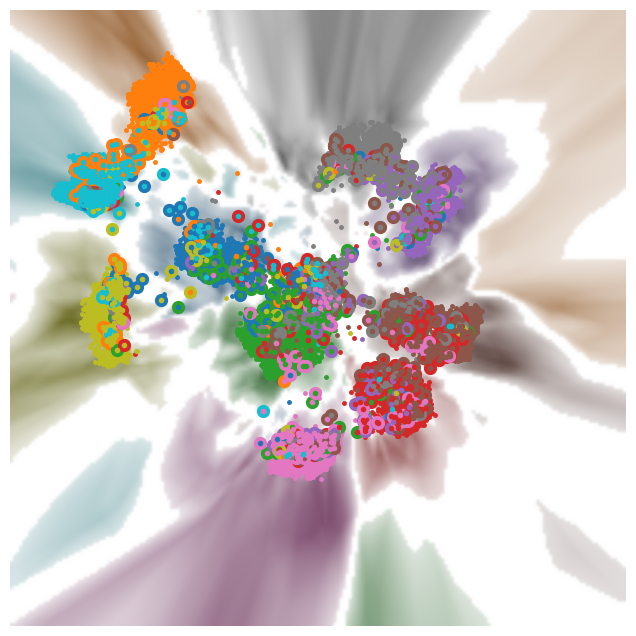

In [23]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVis.visualizerwr import visualizer
from AlignVisAutoEncoder.trans_visualizer import visualizer
vis = visualizer(tar_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yiming/ContrastDebugger' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(130, path=os.path.join("/home/yiming/ContrastDebugger/imgcontrast/AE-img130-flip.png"))